In [1]:
from __future__ import annotations

import importlib
import pathlib
import re
from datetime import datetime

import plotly.express as px
import polars
import theme

importlib.reload(theme)

<module 'theme' from '/Users/jgpaul/workspace/tpds24-evaluation/notebooks/theme.py'>

In [2]:
def read_log(filepath: pathlib.Path | str) -> list[str]:
    with open(filepath) as f:
        return f.readlines()

In [3]:
UUID_PATTERN = '[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}'
DATE_PATTERN = '\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}(?:,|.)\d{3}'
PATTERN = re.compile(
    f'({DATE_PATTERN}).*(EVICT|PROXY|GET|PUT|PROXY).*({UUID_PATTERN})',
)


def parse_line(line: str) -> dict:
    match = PATTERN.match(line)
    if match is None:
        return None
    return {
        'datetime': datetime.strptime(
            match.group(1),
            '%Y-%m-%d %H:%M:%S,%f'
            if ',' in match.group(1)
            else '%Y-%m-%d %H:%M:%S.%f',
        ),
        'operation': match.group(2),
        'uuid': match.group(3),
    }


def parse_events(logs: list[str]) -> polars.DataFrame:
    lines = [x for x in map(parse_line, logs) if x is not None]
    df = polars.from_dicts(lines).sort('datetime')
    df = df.with_columns(
        polars.col('datetime')
        .dt.timestamp('ms')
        .truediv(1000)
        .alias('timestamp'),
    )
    df = df.select(
        polars.col('uuid'),
        polars.col('operation'),
        polars.col('timestamp') - df['timestamp'].min(),
    )
    df = df.pivot(index='uuid', columns='operation', values='timestamp')
    return df


def process(files: dict[str, pathlib.Path | str]) -> polars.DataFrame:
    dfs = []
    for name, filepath in files.items():
        log = read_log(filepath)
        data = parse_events(log)
        data = data.select(polars.lit(name).alias('run'), polars.all())
        dfs.append(data)
    return polars.concat(dfs, how='diagonal')

In [4]:
def get_active_proxies(data: polars.DataFrame, period=10) -> polars.DataFrame:
    data = data.select(
        polars.col('run'),
        polars.col('uuid'),
        polars.col('PROXY'),  # .cast(polars.Int32),
        polars.col('EVICT'),  # .cast(polars.Int32),
    )
    proxy_data = (
        data.pivot(
            values='PROXY',
            index='PROXY',
            columns=('run'),
            aggregate_function='len',
        )
        .select(
            polars.col('PROXY').alias('timestep'),
            polars.col('Baseline').cast(polars.Int32).alias('Baseline-Proxy'),
            polars.col('Ownership')
            .cast(polars.Int32)
            .alias('Ownership-Proxy'),
        )
        .drop_nulls('timestep')
        .fill_null(0)
    )
    evict_data = (
        data.pivot(
            values='EVICT',
            index='EVICT',
            columns=('run'),
            aggregate_function='len',
        )
        .select(
            polars.col('EVICT').alias('timestep'),
            polars.col('Baseline').cast(polars.Int32).alias('Baseline-Evict'),
            polars.col('Ownership')
            .cast(polars.Int32)
            .alias('Ownership-Evict'),
        )
        .drop_nulls('timestep')
        .fill_null(0)
    )
    data = (
        proxy_data.join(evict_data, on='timestep', how='outer_coalesce')
        .fill_null(0)
        .sort('timestep')
    )
    data = data.select(
        polars.col('timestep'),
        (polars.col('Baseline-Proxy') - polars.col('Baseline-Evict')).alias(
            'Baseline',
        ),
        (polars.col('Ownership-Proxy') - polars.col('Ownership-Evict')).alias(
            'Ownership',
        ),
    )
    data = data.select(
        polars.col('timestep'),
        polars.cum_sum('Baseline'),
        polars.cum_sum('Ownership'),
    )
    return data

In [5]:
def generate_figure(data, layout=None):
    data = get_active_proxies(data)
    data = data.melt(id_vars='timestep', value_vars=('Baseline', 'Ownership'))

    colors = {
        'Baseline': theme.colors['green'],
        'Ownership': theme.colors['purple'],
    }

    # Add one to values because we use log scale and 0 won't work
    data = data.with_columns(polars.col('value') + 1)

    fig = px.line(
        data,
        x='timestep',
        y='value',
        color='variable',
        color_discrete_map=colors,
        log_y=True,
    )

    ymax = data['value'].max()
    yaxis_ticks = list(range(len(str(ymax)) + 1))

    layout = {} if layout is None else layout
    fig.update_layout(
        xaxis_title='Runtime (s)',
        yaxis_title='Active Proxies',
        # xaxis_range=[0, xmax],
        yaxis=dict(
            tickmode='array',
            tickvals=[10**e for e in yaxis_ticks],
            ticktext=[f'10<sup>{e}</sup>' for e in yaxis_ticks],
        ),
        legend=dict(
            yanchor='bottom',
            y=0.2,
            xanchor='right',
            x=0.995,
            title=None,
        ),
        template='proxystore',
        **layout,
    )
    return fig

## Single Node Polaris

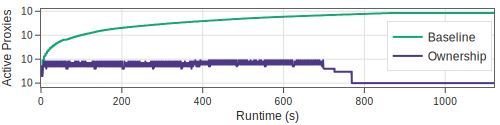

In [6]:
files = {
    'Baseline': '../data/polaris/5-mof-generation/proxystore-baseline-single-node.log',
    'Ownership': '../data/polaris/5-mof-generation/proxystore-ownership-single-node.log',
}
data = process(files)

layout = dict(width=500, height=125, margin=dict(l=5, r=5, t=5, b=5))

fig = generate_figure(data, layout)
fig.show(renderer='svg')

## 10 Node Polaris

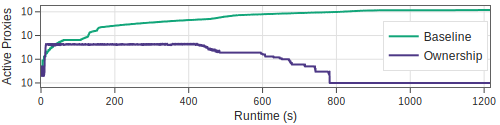

In [7]:
files = {
    'Baseline': '../data/polaris/5-mof-generation/proxystore-baseline-ten-node.log',
    'Ownership': '../data/polaris/5-mof-generation/proxystore-ownership-ten-node.log',
}
data = process(files)

layout = dict(width=500, height=125, margin=dict(l=5, r=5, t=5, b=5))

fig = generate_figure(data, layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '5-mof-generation.pdf')